<div align="center">
<h1><img width="30" src="https://madewithml.com/static/images/rounded_logo.png">&nbsp;<a href="https://madewithml.com/">Made With ML</a></h1>
Applied ML · MLOps · Production
<br>
Join 30K+ developers in learning how to responsibly <a href="https://madewithml.com/about/">deliver value</a> with ML.
    <br>
</div>

<br>

<div align="center">
    <a target="_blank" href="https://newsletter.madewithml.com"><img src="https://img.shields.io/badge/Subscribe-30K-brightgreen"></a>&nbsp;
    <a target="_blank" href="https://github.com/GokuMohandas/MadeWithML"><img src="https://img.shields.io/github/stars/GokuMohandas/MadeWithML.svg?style=social&label=Star"></a>&nbsp;
    <a target="_blank" href="https://www.linkedin.com/in/goku"><img src="https://img.shields.io/badge/style--5eba00.svg?label=LinkedIn&logo=linkedin&style=social"></a>&nbsp;
    <a target="_blank" href="https://twitter.com/GokuMohandas"><img src="https://img.shields.io/twitter/follow/GokuMohandas.svg?label=Follow&style=social"></a>
    <br>
    🔥&nbsp; Among the <a href="https://github.com/topics/mlops" target="_blank">top MLOps</a> repositories on GitHub
</div>

<br>
<hr>

# Set up

In [ ]:
# High quality plots
%config InlineBackend.figure_format = "svg"

In [ ]:
# Install Alibi (Seldon)
!pip install alibi-detect -q
!pip freeze | grep alibi-detect

alibi-detect==0.6.2


# Performance

Illustrating the need to monitor metrics at various window sizes to catch performance degradation as soon as possible. Here we're monitoring an overall metric but we can do the same for slices of data, individual classes, etc. For example, if we monitor the performance on a specific tag, we may be able to quickly catch new algorithms that were released for that tag (ex. new transformer architecture).

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme()

In [ ]:
# Generate data
hourly_f1 = list(np.random.uniform(94, 98, 24*20)) + \
            list(np.random.uniform(92, 96, 24*5)) + \
            list(np.random.uniform(88, 96, 24*5)) + \
            list(np.random.uniform(86, 92, 24*5))

In [ ]:
# Rolling f1
rolling_f1 = [np.mean(hourly_f1[:n]) for n in range(1, len(hourly_f1)+1)]
print (f"Average rolling f1 on the last day: {np.mean(rolling_f1[-24:]):.1f}")

Average rolling f1 on the last day: 94.1


In [ ]:
# Window f1
window_size = 24
window_f1 = np.convolve(hourly_f1, np.ones(window_size)/window_size, mode="valid")
print (f"Average window f1 on the last day: {np.mean(window_f1[-24:]):.1f}")

Average window f1 on the last day: 88.9


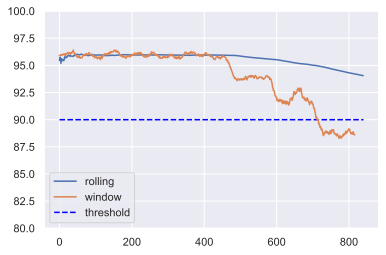

In [ ]:
plt.ylim([80, 100])
plt.hlines(y=90, xmin=0, xmax=len(hourly_f1), colors="blue", linestyles="dashed", label="threshold")
plt.plot(rolling_f1, label="rolling")
plt.plot(window_f1, label="window")
plt.legend()

In [ ]:
# Generate data
gradual = list(np.random.uniform(96, 98, 20)) + \
          list(np.random.uniform(94, 96, 20)) + \
          list(np.random.uniform(92, 94, 20)) + \
          list(np.random.uniform(90, 92, 20))
abrupt =  list(np.random.uniform(92, 94, 20)) + \
          list(np.random.uniform(90, 92, 20)) + \
          list(np.random.uniform(78, 80, 40))
periodic = list(np.random.uniform(87, 89, 15)) + \
           list(np.random.uniform(81, 85, 25)) + \
           list(np.random.uniform(87, 89, 15)) + \
           list(np.random.uniform(81, 85, 25))

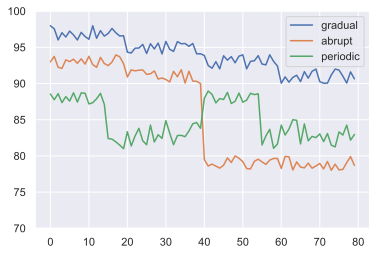

In [ ]:
plt.ylim([70, 100])
plt.plot(gradual, label="gradual")
plt.plot(abrupt, label="abrupt")
plt.plot(periodic, label="periodic")
plt.legend()

# Data

In [ ]:
import great_expectations as ge
import pandas as pd
from pathlib import Path
from app import config
from tagifai import utils

In [ ]:
# Create DataFrame
features_fp = Path(config.DATA_DIR, "features.json")
features = utils.load_dict(filepath=features_fp)
df = ge.dataset.PandasDataset(features)

# Expectations

Rule-based expectations that must pass.

In [ ]:
# Simulated production data
prod_df = ge.dataset.PandasDataset([{"text": "hello"}, {"text": 0}, {"text": "world"}])

In [ ]:
# Expectation suite
df.expect_column_values_to_not_be_null(column="text")
df.expect_column_values_to_be_of_type(column="text", type_="str")
expectation_suite = df.get_expectation_suite()

In [ ]:
# Validate reference data
df.validate(expectation_suite=expectation_suite, only_return_failures=True)["statistics"]

{'evaluated_expectations': 2,
 'successful_expectations': 2,
 'unsuccessful_expectations': 0,
 'success_percent': 100.0}

In [ ]:
# Validate production data
prod_df.validate(expectation_suite=expectation_suite, only_return_failures=True)["statistics"]

{'evaluated_expectations': 2,
 'successful_expectations': 1,
 'unsuccessful_expectations': 1,
 'success_percent': 50.0}

# Drift detection on univariate data

### Kolmogorov-Smirnov (KS) test

KS test for detecting data drift on input sequence length. We can monitor aspects of our data that aren't necessarily inputs to the model (ex. length of input text).

In [ ]:
from alibi_detect.cd import KSDrift

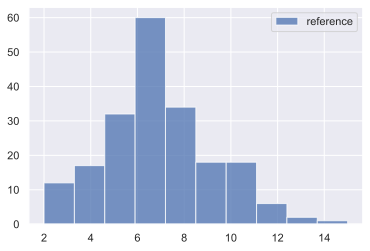

In [ ]:
# Reference
df["num_tags"] = df.tags.apply(lambda x: len(x))
reference = df["num_tags"][-400:-200].to_numpy()
plt.hist(reference, alpha=0.75, label="reference")
plt.legend()
plt.show()

In [ ]:
# Initialize drift detector
length_drift_detector = KSDrift(reference, p_val=0.01)

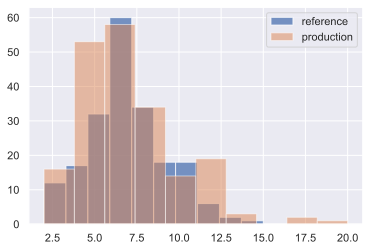

In [ ]:
# No drift
no_drift = df["num_tags"][-200:].to_numpy()
length_drift_detector.predict(no_drift, return_p_val=True, return_distance=True)
plt.hist(reference, alpha=0.75, label="reference")
plt.hist(no_drift, alpha=0.5, label="production")
plt.legend()
plt.show()

In [ ]:
# Predict on no drift data
length_drift_detector.predict(no_drift, return_p_val=True, return_distance=True)

{'data': {'is_drift': 0,
  'distance': array([0.06], dtype=float32),
  'p_val': array([0.8428848], dtype=float32),
  'threshold': 0.01},
 'meta': {'name': 'KSDrift', 'detector_type': 'offline', 'data_type': None}}

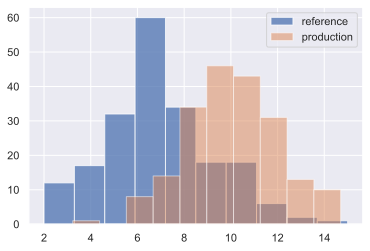

In [ ]:
# Drift
drift = np.random.normal(10, 2, len(reference))
length_drift_detector.predict(drift, return_p_val=True, return_distance=True)
plt.hist(reference, alpha=0.75, label="reference")
plt.hist(drift, alpha=0.5, label="production")
plt.legend()
plt.show()

In [ ]:
# Predict on drift data
length_drift_detector.predict(drift, return_p_val=True, return_distance=True)

{'data': {'is_drift': 1,
  'distance': array([0.645], dtype=float32),
  'p_val': array([4.444e-41], dtype=float32),
  'threshold': 0.01},
 'meta': {'name': 'KSDrift', 'detector_type': 'offline', 'data_type': None}}

### Chi-squared test

Detecting drift on categorical variables (can be used for data or target drift).

In [ ]:
from alibi_detect.cd import ChiSquareDrift

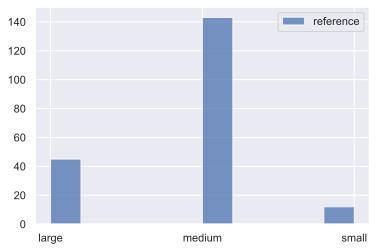

In [ ]:
# Reference
df.tag_count = df.tags.apply(lambda x: "small" if len(x) <= 3 else ("medium" if len(x) <= 8 else "large"))
reference = df.tag_count[-400:-200].to_numpy()
plt.hist(reference, alpha=0.75, label="reference")
plt.legend()
target_drift_detector = ChiSquareDrift(reference, p_val=0.01)

{'data': {'is_drift': 0,
  'distance': array([2.008658], dtype=float32),
  'p_val': array([0.36629033], dtype=float32),
  'threshold': 0.01},
 'meta': {'name': 'ChiSquareDrift',
  'detector_type': 'offline',
  'data_type': None}}

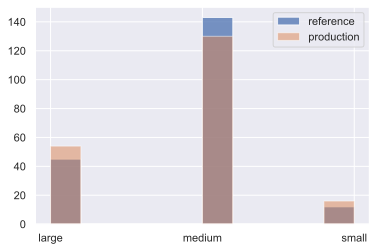

In [ ]:
# No drift
no_drift = df.tag_count[-200:].to_numpy()
plt.hist(reference, alpha=0.75, label="reference")
plt.hist(no_drift, alpha=0.5, label="production")
plt.legend()
target_drift_detector.predict(no_drift, return_p_val=True, return_distance=True)

{'data': {'is_drift': 1,
  'distance': array([118.03355], dtype=float32),
  'p_val': array([2.3406739e-26], dtype=float32),
  'threshold': 0.01},
 'meta': {'name': 'ChiSquareDrift',
  'detector_type': 'offline',
  'data_type': None}}

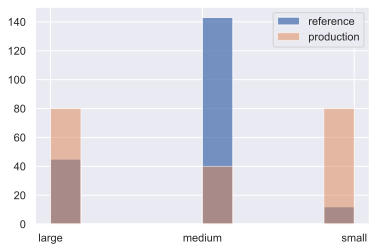

In [ ]:
# Drift
drift = np.array(["small"]*80 + ["medium"]*40 + ["large"]*80)
plt.hist(reference, alpha=0.75, label="reference")
plt.hist(drift, alpha=0.5, label="production")
plt.legend()
target_drift_detector.predict(drift, return_p_val=True, return_distance=True)

# Drfit detection on multivariate data 

We can't use encoded text because each character's categorical representation is arbitrary. However, the embedded text's representation does capture semantic meaning which makes it possible for us to detect drift on. With tabular data and images, we can use those numerical representation as is (can preprocess if needed) since the values are innately meaningful.

In [ ]:
import torch
import torch.nn as nn
from tagifai import data, main

In [ ]:
# Set device
device = utils.set_device(cuda=False)

In [ ]:
# Load model
run_id = open(Path(config.MODEL_DIR, "run_id.txt")).read()
artifacts = main.load_artifacts(run_id=run_id)

In [ ]:
# Retrieve artifacts
params = artifacts["params"]
label_encoder = artifacts["label_encoder"]
tokenizer = artifacts["tokenizer"]
embeddings_layer = artifacts["model"].embeddings
embedding_dim = embeddings_layer.embedding_dim

In [ ]:
def get_data_tensor(texts):
    preprocessed_texts = [data.preprocess(text, lower=params.lower, stem=params.stem) for text in texts]
    X = np.array(tokenizer.texts_to_sequences(preprocessed_texts), dtype="object")
    y_filler = np.zeros((len(X), len(label_encoder)))
    dataset = data.CNNTextDataset(X=X, y=y_filler, max_filter_size=int(params.max_filter_size))
    dataloader = dataset.create_dataloader(batch_size=len(texts))
    return next(iter(dataloader))[0]

In [ ]:
# Reference
reference = get_data_tensor(texts=df.text[-400:-200].to_list())
reference.shape

torch.Size([200, 186])

### Dimensionality reduction (via UAE)

In [ ]:
from functools import partial
from alibi_detect.cd.pytorch import preprocess_drift

In [ ]:
# Untrained autoencoder (UAE) reducer
enc_dim = 32 
reducer = nn.Sequential(
    embeddings_layer,
    nn.AdaptiveAvgPool2d((1, embedding_dim)),
    nn.Flatten(),
    nn.Linear(embedding_dim, 256),
    nn.ReLU(),
    nn.Linear(256, enc_dim)
).to(device).eval()

In [ ]:
# Preprocessing with the reducer
preprocess_fn = partial(preprocess_drift, model=reducer, batch_size=params.batch_size)

### Maximum Mean Discrepancy (MMD)

In [ ]:
from alibi_detect.cd import MMDDrift

In [ ]:
# Initialize drift detector
embeddings_mmd_drift_detector = MMDDrift(reference, backend="pytorch", p_val=.01, preprocess_fn=preprocess_fn)

No GPU detected, fall back on CPU.


In [ ]:
# No drift
no_drift = get_data_tensor(texts=df.text[-200:].to_list())
embeddings_mmd_drift_detector.predict(no_drift)

{'data': {'is_drift': 0,
  'distance': 0.0025458335876464844,
  'p_val': 0.10999999940395355,
  'threshold': 0.01,
  'distance_threshold': 0.008433938},
 'meta': {'name': 'MMDDriftTorch',
  'detector_type': 'offline',
  'data_type': None,
  'backend': 'pytorch'}}

In [ ]:
# No drift (with benign injection)
texts = ["BERT " + text for text in df.text[-200:].to_list()]
drift = get_data_tensor(texts=texts)
embeddings_mmd_drift_detector.predict(drift)

{'data': {'is_drift': 0,
  'distance': 0.004854023456573486,
  'p_val': 0.019999999552965164,
  'threshold': 0.01,
  'distance_threshold': 0.0054801106},
 'meta': {'name': 'MMDDriftTorch',
  'detector_type': 'offline',
  'data_type': None,
  'backend': 'pytorch'}}

In [ ]:
# Drift
texts = ["UNK " + text for text in df.text[-200:].to_list()]
drift = get_data_tensor(texts=texts)
embeddings_mmd_drift_detector.predict(drift)

{'data': {'is_drift': 1,
  'distance': 0.012179732322692871,
  'p_val': 0.0,
  'threshold': 0.01,
  'distance_threshold': 0.0058291554},
 'meta': {'name': 'MMDDriftTorch',
  'detector_type': 'offline',
  'data_type': None,
  'backend': 'pytorch'}}

We could repeat this process for tensor outputs at various layers in our model (embedding, conv layers, softmax, etc.). Just keep in mind that our outputs from the reducer need to be a 2D matrix so we may need to do additional preprocessing such as pooling 3D embedding tensors. 
> [TorchDrift](https://torchdrift.org/) is another great package that offers a suite of reducers (PCA, AE, etc.) and drift detectors (MMD) to monitor for drift at any stage in our model.

### Kolmogorov-Smirnov (KS) test + Bonferroni correction

In [ ]:
# Initialize drift detector
embeddings_ks_drift_detector = KSDrift(reference, p_val=.01, preprocess_fn=preprocess_fn, correction="bonferroni")

In [ ]:
# No drift
no_drift = get_data_tensor(texts=df.text[-200:].to_list())
embeddings_ks_drift_detector.predict(no_drift)

{'data': {'is_drift': 0,
  'distance': array([0.08 , 0.13 , 0.1  , 0.065, 0.085, 0.085, 0.09 , 0.125, 0.085,
         0.05 , 0.14 , 0.085, 0.055, 0.145, 0.065, 0.105, 0.085, 0.085,
         0.195, 0.085, 0.07 , 0.115, 0.085, 0.115, 0.105, 0.085, 0.06 ,
         0.11 , 0.05 , 0.135, 0.1  , 0.065], dtype=float32),
  'p_val': array([5.1821935e-01, 6.2092341e-02, 2.5269276e-01, 7.6719129e-01,
         4.4107372e-01, 4.4107372e-01, 3.7063202e-01, 8.0500402e-02,
         4.4107372e-01, 9.5321596e-01, 3.5825118e-02, 4.4107372e-01,
         9.0635681e-01, 2.6797028e-02, 7.6719129e-01, 2.0524779e-01,
         4.4107372e-01, 4.4107372e-01, 8.3207304e-04, 4.4107372e-01,
         6.8467069e-01, 1.3121547e-01, 4.4107372e-01, 1.3121547e-01,
         2.0524779e-01, 4.4107372e-01, 8.4288478e-01, 1.6496263e-01,
         9.5321596e-01, 4.7406290e-02, 2.5269276e-01, 7.6719129e-01],
        dtype=float32),
  'threshold': 0.0003125},
 'meta': {'name': 'KSDrift', 'detector_type': 'offline', 'data_type': Non

In [ ]:
# Drift
texts = ["UNK " + text for text in df.text[-200:].to_list()]
drift = get_data_tensor(texts=texts)
embeddings_ks_drift_detector.predict(drift)

{'data': {'is_drift': 1,
  'distance': array([0.07 , 0.215, 0.095, 0.075, 0.18 , 0.05 , 0.07 , 0.12 , 0.085,
         0.055, 0.23 , 0.105, 0.13 , 0.18 , 0.12 , 0.065, 0.08 , 0.14 ,
         0.21 , 0.1  , 0.08 , 0.155, 0.185, 0.135, 0.145, 0.11 , 0.09 ,
         0.11 , 0.045, 0.11 , 0.165, 0.1  ], dtype=float32),
  'p_val': array([6.84670687e-01, 1.54796828e-04, 3.07758421e-01, 6.00350142e-01,
         2.63004983e-03, 9.53215957e-01, 6.84670687e-01, 1.03303745e-01,
         4.41073716e-01, 9.06356812e-01, 3.92192451e-05, 2.05247790e-01,
         6.20923415e-02, 2.63004983e-03, 1.03303745e-01, 7.67191291e-01,
         5.18219352e-01, 3.58251184e-02, 2.39473447e-04, 2.52692759e-01,
         5.18219352e-01, 1.45376530e-02, 1.81096233e-03, 4.74062897e-02,
         2.67970283e-02, 1.64962634e-01, 3.70632023e-01, 1.64962634e-01,
         9.81954396e-01, 1.64962634e-01, 7.56811490e-03, 2.52692759e-01],
        dtype=float32),
  'threshold': 0.0003125},
 'meta': {'name': 'KSDrift', 'detector_ty

Note that each feature (`enc_dim`=32) has a distance and an associated p-value.